# Setting up the Simple `TUM`

In [1]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
import numpy as np
session = Session(None)  # Used to run the TensorFlow graph

%load_ext autoreload
%autoreload 2

Could not load resample cuda libraries: CUDA binaries not found at /home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them







In [2]:
#setup

save_imgs = True
res = 8
buoyancy = 0.0
rate = 5
radius = 2

In [3]:
#Create the optimizable simulation
#buoyancy is set to zero

world = World()
fluid = world.add(Fluid(Domain([2*res, 3*res], boundaries=CLOSED), buoyancy_factor=buoyancy), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[0.3*res,1.5*res], radius=radius), rate=rate))
world.add(Inflow(Sphere(center=[0.3*res,0.75*res], radius=radius), rate=rate))
world.add(Inflow(Sphere(center=[0.3*res,2.25*res], radius=radius), rate=rate))
#world.add(Inflow(box[0.1*res:0.35*res, 0.5*res:2.5*res], rate = rate))

fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
states = []
states.append(fluid.state)  # Remember the state at t=0 for later visualization
session.initialize_variables()



In [4]:
#See tensorflow variables
[print(grid.data) for grid in fluid.velocity.unstack()];

<tf.Variable 'Variable/data/0/data:0' shape=(1, 17, 24, 1) dtype=float32_ref>
<tf.Variable 'Variable/data/1/data:0' shape=(1, 16, 25, 1) dtype=float32_ref>


Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Building graph for frame 10
Building graph for frame 11
Building graph for frame 12
Building graph for frame 13
Building graph for frame 14
Building graph for frame 15
Building graph for frame 16
Building graph for frame 17
Building graph for frame 18
Building graph for frame 19
Building graph for frame 20
Building graph for frame 21
Building graph for frame 22
Building graph for frame 23
Building graph for frame 24
Building graph for frame 25
Building graph for frame 26
Building graph for frame 27
Building graph for frame 28
Building graph for frame 29
Building graph for frame 30
Building graph for frame 31
Building graph for frame 32
Building graph for frame 33
Building graph for frame 34
Building graph for frame 35
Bu

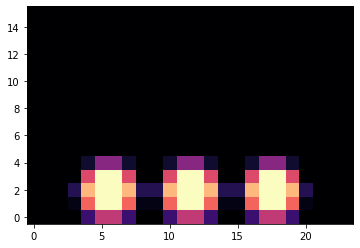

In [5]:
#Build graphs for the simulation
for frame in range(50):
  print('Building graph for frame %d' % frame)
  world.step(dt=0.5)
  states.append(fluid.state)


print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [6]:
#Define the target (a png image converted to numpy)
import imageio

target = imageio.imread('tum/tum_08.png')
target = target[:,:,0]
target = np.flip(target)
target = target[:,::-1]
target = np.expand_dims(target, axis=0)
target = np.expand_dims(target, axis=3)

val1 = np.max(fluid.density.data[0:,...])
val2 = np.max(target)
target = val1/val2 * target #normalize the target values to have similar magnitude to the simulation densities

#Define loss, optimizer and start the session
loss = math.l2_loss(fluid.density.data[0:,...] - target)
optim = tf.train.AdamOptimizer(learning_rate=0.25).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session.run(loss))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initial loss: 3517015.500000


In [7]:
#Run optimization

for optim_step in range(100):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 3517015.500000
Running optimization step 1. 
Loss: 3332979.250000
Running optimization step 2. 
Loss: 3275586.500000
Running optimization step 3. 
Loss: 3244541.000000
Running optimization step 4. 
Loss: 3215570.000000
Running optimization step 5. 
Loss: 3184809.750000
Running optimization step 6. 
Loss: 3166660.250000
Running optimization step 7. 
Loss: 3159864.250000
Running optimization step 8. 
Loss: 3148300.250000
Running optimization step 9. 
Loss: 3134955.000000
Running optimization step 10. 
Loss: 3127038.500000
Running optimization step 11. 
Loss: 3122041.000000
Running optimization step 12. 
Loss: 3117738.000000
Running optimization step 13. 
Loss: 3113576.000000
Running optimization step 14. 
Loss: 3109682.000000
Running optimization step 15. 
Loss: 3105719.250000
Running optimization step 16. 
Loss: 3101732.750000
Running optimization step 17. 
Loss: 3098789.500000
Running optimization step 18. 
Lo

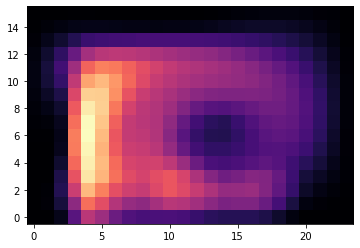

In [8]:
#See what this thing did

pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [9]:
#Checkout the optimized velocity field

optimized_velocity_field = session.run(states[0].velocity).at_centers()

In [ ]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

In [ ]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

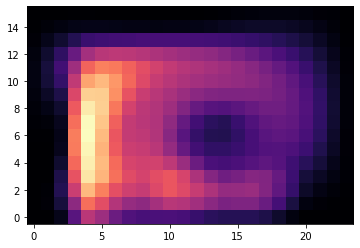

In [10]:
#Saving the optimized density fields as images

if (save_imgs):
    for i in range(len(states)):
        save_name = "tum/vis/tum%02d_frame%03d.png"
        pylab.imshow(np.concatenate(session.run(states[i].density).data[...,0], axis=1), origin='lower', cmap='magma')
        print("Saving image frame %d" % i)
        pylab.savefig(save_name % (res, i), bbox_inches='tight')


In [ ]:
###For Google collab

#!zip -r /content/file.zip /content/
#from google.colab import files
#files.download("/content/file.zip")